In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.4 anndata==0.11.1 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.0 igraph==0.11.5 pynndescent==0.5.12


In [2]:
nr = sc.read_h5ad('./V1_NR_L23_filter.h5ad')
dr = sc.read_h5ad('./V1_DR_L23_filter.h5ad')

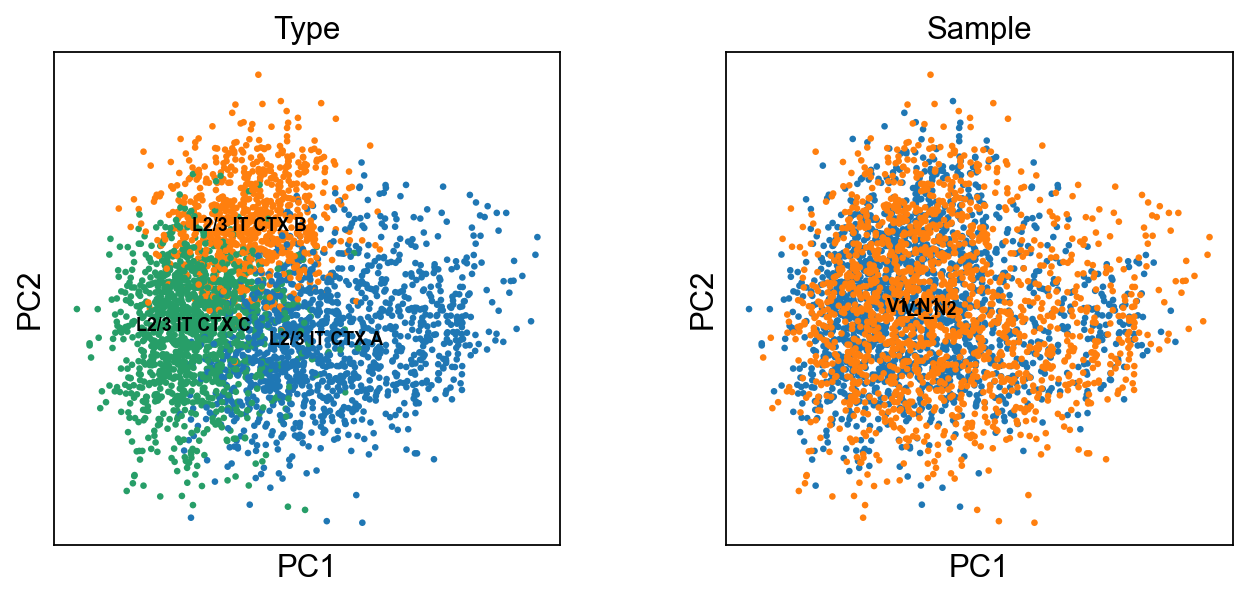

In [3]:
sc.pl.pca(nr,color=["Type","Sample"],legend_fontsize=8,legend_loc="on data")

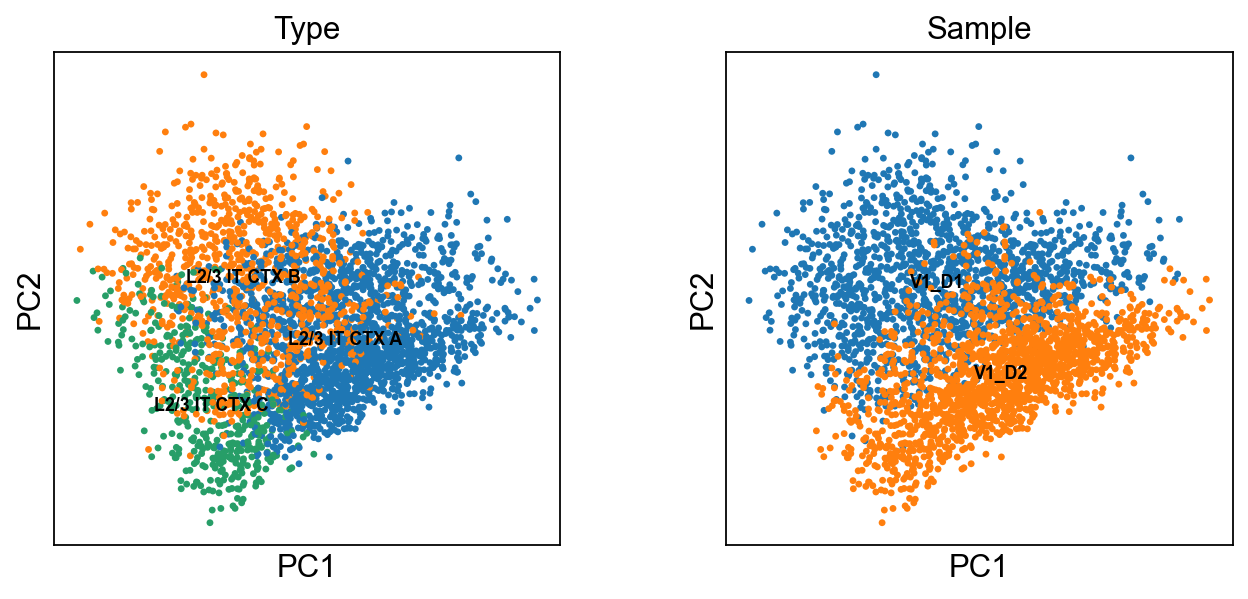

In [4]:
sc.pl.pca(dr,color=["Type","Sample"],legend_fontsize=8,legend_loc="on data")

In [5]:
nr

AnnData object with n_obs × n_vars = 3376 × 22105
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Class', 'preclass', 'cluster', 'Subclass', 'Sample', 'Type', 'Subtype', 'Cell_annotation'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Class_colors', 'Sample_colors', 'Subclass_colors', 'Subtype_colors', 'Type_colors', 'cluster_colors', 'hvg', 'leiden_res_0.80', 'leiden_res_0.80_colors', 'leiden_res_1.00', 'leiden_res_1.00_colors', 'leiden_res_1.20', 'leiden_res_1.20_colors', 'neighbors', 'pca', 'preclass_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [3]:
import anndata 
from scipy.stats import zscore
from scipy import sparse 
import itertools
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from umap import UMAP
from py_pcha import PCHA
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances_argmin
import seaborn as sns

ranking genes
    finished: added to `.uns['t-test_bh']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


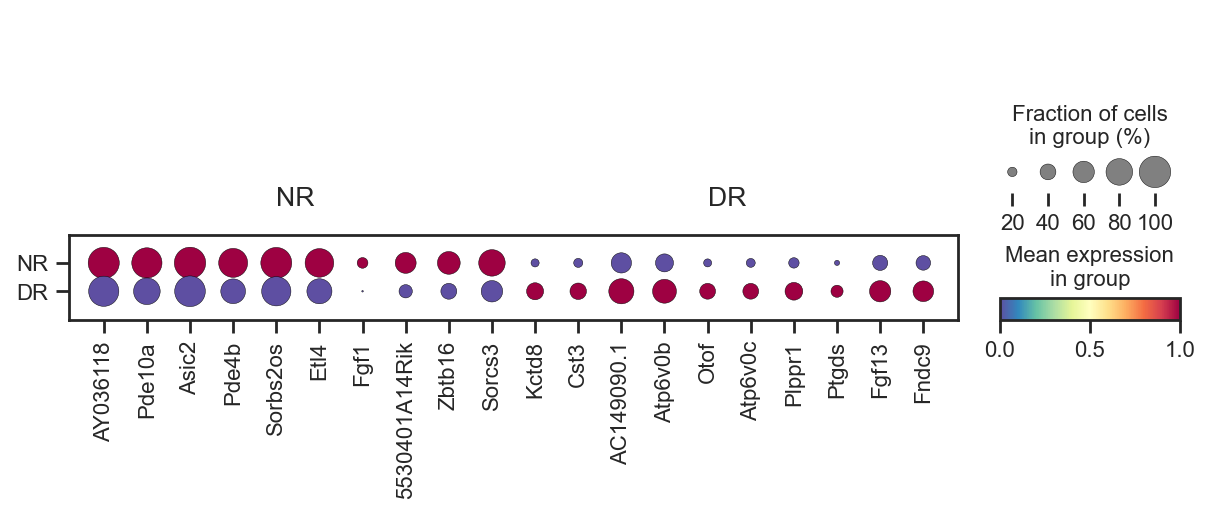

In [80]:
sc.tl.rank_genes_groups(adata, groupby='cond',groups='all', reference='rest', method='t-test',pts=True,corr_method='benjamini-hochberg',key_added='t-test_bh')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10,groupby='cond',cmap='Spectral_r', standard_scale='var',key='t-test_bh',min_logfoldchange=1)
df_subclass=sc.get.rank_genes_groups_df(adata, group='DR',key='t-test_bh')

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_63766/959317621.py:12: RuntimeWarning:

divide by zero encountered in log10

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10



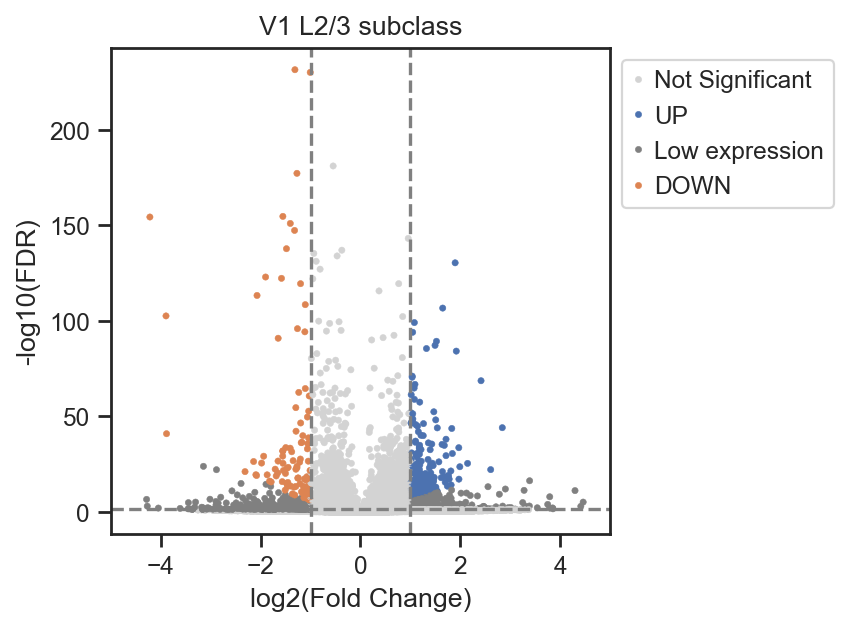

In [81]:
df = pd.DataFrame()
gene = list(df_subclass['names'])
log2FoldChange = list(df_subclass['logfoldchanges'])
pvalue = list(df_subclass['pvals'])
FDR = list(df_subclass['pvals_adj'])
pts_u = list(df_subclass['pct_nz_group'])
pts_d = list(df_subclass['pct_nz_reference'])
df['gene'] = gene
df['log2FoldChange'] = log2FoldChange
df['pvalue'] = pvalue
df['FDR'] = FDR
df['-log10(FDR)'] = df['FDR'].apply(lambda x: -np.log10(x))
df['pts_u'] = pts_u
df['pts_d'] = pts_d


padj_threshold = 0.05
log2fc_threshold = 1.0


df['significance'] = 'Not Significant'
df.loc[(df['FDR'] < padj_threshold) & (df['log2FoldChange'] >= log2fc_threshold) & (df['pts_u'] > 0.05), 'significance']  = 'UP'
df.loc[(df['FDR'] < padj_threshold) & (df['log2FoldChange'] <= -log2fc_threshold) & (df['pts_d'] > 0.05), 'significance'] = 'DOWN'
#df.loc[df['gene'].isin(marker), 'significance'] = 'Marker gene'
df.loc[(df['FDR'] < padj_threshold) & (df['log2FoldChange'] >= log2fc_threshold) & (df['pts_u'] < 0.05), 'significance']  = 'Low expression'
df.loc[(df['FDR'] < padj_threshold) & (df['log2FoldChange'] <= -log2fc_threshold) & (df['pts_d'] < 0.05), 'significance']  = 'Low expression'

plt.figure(figsize=(4, 4))
sns.scatterplot(data=df, x='log2FoldChange', y=-np.log10(df['FDR']), hue='significance', s= 8, palette={'UP':'C0','DOWN': 'C1', 'Not Significant': 'lightgray','Low expression':'gray'}, edgecolor=None)


plt.axhline(y=-np.log10(padj_threshold), color='grey', linestyle='--')
plt.axvline(x=log2fc_threshold, color='grey', linestyle='--')
plt.axvline(x=-log2fc_threshold, color='grey', linestyle='--')

plt.xlabel('log2(Fold Change)')
plt.ylabel('-log10(FDR)')
plt.title('V1 L2/3 subclass')
plt.legend(title='Significance')
plt.xlim((-5,5))
#plt.ylim((-2,50))
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('V1_L23_subclass_filter.pdf')

In [82]:
df.to_csv('V1_L23_subclass_DEG_filter.xls',index=True,sep='\t')

In [83]:
df_sig = df[df['significance'].isin (['UP','DOWN'])]


In [84]:
df_sig.shape

(364, 8)

In [85]:
df_sig['significance'].value_counts()

significance
UP      263
DOWN    101
Name: count, dtype: int64